In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import numpy as np
import pandas as pd
import matplotlib

In [4]:
df = pd.read_csv("data/contamination_fracking.csv")
df.dropna(inplace=True)
df = df[~df['State'].apply(lambda x: str(x).isdigit())] # in some cases State is reported as a number
df.head()

,Unnamed: 0,level_0,CollectionDate,FacilityID,State,ContaminantCount,index,FacilityWaterType,Zip,LatitudePWS,...,PercentHighAdditive,PercentHFJob,IngredientName,Purpose,Supplier,JobDuration,TotalBaseWaterVolume,TotalBaseNonWaterVolume,distance_nearest,distance_20_nearest
1,1,13420,2014-02-06,1,CA,28,67540,SW,91802,33.786594,...,30.000000,1.729810,"('1-butoxy-2-propanol', 'Calcined Diatomaceous...","('Scale Inhibitor', 'Degradable Sealers', 'Bre...","('Baker Hughes', 'Other Chemicals', 'Operator')",1.0,287133.0,0.0,11.066041,11.722878
4,4,13423,2014-02-06,1,FL,28,89596,GW,32353,30.549676,...,36.573585,1.897712,"('2-Butoxyethanol', 'Ethoxylated Nonylphenol',...","('Water', 'Bulk Acid', 'Other Ingredients', 'A...","('SAGA PETROLEUM', 'Nabors Completion and Prod...",0.0,53000.0,0.0,4.053320,7.282085
5,5,13424,2014-02-06,1,MA,21,55442,GW,1720,42.477142,...,27.013514,2.688290,"('2-Butoxyethanol', 'C-14 N-Alkanes', 'Proparg...","('Non-Emulsifier', 'Iron Control', 'Breaker', ...","('Chemplex', 'Rain for Rent', 'Reagent', 'TSS')",15.0,12878460.0,0.0,4.174925,4.437170
6,6,13425,2014-02-06,1,MD,26,50446,SW,21078,39.554644,...,32.940000,2.857143,"('Diethylene Glycol', 'Di Water', 'Copolymer o...","('Anti-Bacterial Agent', 'Scale Inhibitor', 'B...","('U.S. Well Services', 'Inflection Energy', 'U...",5.0,6132042.0,0.0,1.922339,2.061130
7,7,13426,2014-02-06,1,MN,21,39511,SW,55427,45.006764,...,23.654167,4.147837,"('Silica, Amorphous', 'Nonionic Alkoxylate', '...","('Scale Inhibitor', 'Breaker', 'Carrier', 'Oth...","('Trican', nan, 'Customer')",1.0,90509.0,0.0,8.230094,8.549826


In [5]:
print(df.columns)
print(df.shape)
print(df.State.unique())
print(df.groupby('State', as_index=False)['distance_nearest'].mean())
print(df.groupby('State', as_index=False)['distance_20_nearest'].mean())
dftmp = df.groupby('State', as_index=False)['distance_20_nearest'].mean()
states_common = dftmp[dftmp['distance_20_nearest'] <2 ].State.unique()
states_sparse = dftmp[dftmp['distance_20_nearest'] >=2 ].State.unique()
print(states_common)
print(states_sparse)


Index(['Unnamed: 0', 'level_0', 'CollectionDate', 'FacilityID', 'State',
       'ContaminantCount', 'index', 'FacilityWaterType', 'Zip', 'LatitudePWS',
       'LongitudePWS', 'IsContaminated', 'SizeBool', 'sampleId', 'geometry',
       'LatitudeFracking', 'LongitudeFracking', 'JobEndDate',
       'PercentHighAdditive', 'PercentHFJob', 'IngredientName', 'Purpose',
       'Supplier', 'JobDuration', 'TotalBaseWaterVolume',
       'TotalBaseNonWaterVolume', 'distance_nearest', 'distance_20_nearest'],
      dtype='object')
(23498, 28)
['CA' 'FL' 'MA' 'MD' 'MN' 'NC' 'NE' 'NH' 'NY' 'OR' 'PA' 'TN' 'UT' 'VI'
 'VT' 'WA' 'WI' 'CO' 'KS' 'RI' 'ID' 'SD' 'AR' 'HI' 'AZ' 'GA' 'KY' 'IA'
 'VA' 'TX' 'NJ' 'NV' 'ME' 'SC' 'ND' 'MT' 'DE' 'WV' 'MI' 'LA' 'NM' 'AL'
 'MO' 'IN' 'IL' 'OK' 'CT' 'OH' 'MS' 'AK' 'WY' 'PR' 'NN' 'AS']
   State  distance_nearest
0     AK         43.885362
1     AL          1.196160
2     AR          0.666612
3     AS         76.471819
4     AZ          5.093664
5     CA         11.832887


In [6]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
df_ohe = df.copy()
#print(df_ohe.columns)
#df_ohe = df_ohe[df_ohe.State.isin(states_common)]
#print(type(df_ohe))
for col in ['FacilityWaterType','State']:
    ohe = pd.get_dummies(df_ohe[col], prefix='{}'.format(col))
    df_ohe = df_ohe.drop(col, 1) # drop the column that we are OHE-ing
    df_ohe = pd.concat([df_ohe.reset_index(drop=True), ohe.reset_index(drop=True)], axis=1)
print(df_ohe.shape)

(23498, 84)


In [7]:
df_ohe = df_ohe.drop(['Unnamed: 0', # artifact of KNN
                      'level_0', # artifact of merging
                      'index', # artifact of merging
                      'sampleId', # artifact of EDA
                      'geometry', # artifact of KNN
                      'JobEndDate', # will use duration instead of end date
                      'IngredientName', # not currently encoding this
                      'Zip', # not currently encoding this
                      'CollectionDate', # do not need this
                      'Supplier', # not currently encoding this
                      'Purpose', # not currently encoding this 
                     ], axis=1)
print(df_ohe.columns)
df_ohe.head()

Index(['FacilityID', 'ContaminantCount', 'LatitudePWS', 'LongitudePWS',
       'IsContaminated', 'SizeBool', 'LatitudeFracking', 'LongitudeFracking',
       'PercentHighAdditive', 'PercentHFJob', 'JobDuration',
       'TotalBaseWaterVolume', 'TotalBaseNonWaterVolume', 'distance_nearest',
       'distance_20_nearest', 'FacilityWaterType_GU', 'FacilityWaterType_GW',
       'FacilityWaterType_MX', 'FacilityWaterType_SW', 'State_AK', 'State_AL',
       'State_AR', 'State_AS', 'State_AZ', 'State_CA', 'State_CO', 'State_CT',
       'State_DE', 'State_FL', 'State_GA', 'State_HI', 'State_IA', 'State_ID',
       'State_IL', 'State_IN', 'State_KS', 'State_KY', 'State_LA', 'State_MA',
       'State_MD', 'State_ME', 'State_MI', 'State_MN', 'State_MO', 'State_MS',
       'State_MT', 'State_NC', 'State_ND', 'State_NE', 'State_NH', 'State_NJ',
       'State_NM', 'State_NN', 'State_NV', 'State_NY', 'State_OH', 'State_OK',
       'State_OR', 'State_PA', 'State_PR', 'State_RI', 'State_SC', 'State_SD',
 

,FacilityID,ContaminantCount,LatitudePWS,LongitudePWS,IsContaminated,SizeBool,LatitudeFracking,LongitudeFracking,PercentHighAdditive,PercentHFJob,...,State_TN,State_TX,State_UT,State_VA,State_VI,State_VT,State_WA,State_WI,State_WV,State_WY
0,1,28,33.786594,-118.298662,1,0,36.200230,-107.499050,30.000000,1.729810,...,0,0,0,0,0,0,0,0,0,0
1,1,28,30.549676,-84.606864,0,0,33.406510,-87.482260,36.573585,1.897712,...,0,0,0,0,0,0,0,0,0,0
2,1,21,42.477142,-71.442200,0,0,41.812000,-75.563800,27.013514,2.688290,...,0,0,0,0,0,0,0,0,0,0
3,1,26,39.554644,-76.111180,0,0,41.312447,-76.889328,32.940000,2.857143,...,0,0,0,0,0,0,0,0,0,0
4,1,21,45.006764,-93.382230,0,0,48.960520,-100.600420,23.654167,4.147837,...,0,0,0,0,0,0,0,0,0,0


In [9]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, TensorDataset
import tqdm 
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm.notebook import tqdm, trange
from ipywidgets import IntProgress
from sklearn import preprocessing

df_ohe['CCCategory'] = df_ohe.apply(lambda row: 6 if row.ContaminantCount > 30 else row.ContaminantCount//6, axis=1)
y = df_ohe['CCCategory'].values
output_dim = len(df_ohe['CCCategory'].unique())
df_ohe = df_ohe.drop(['CCCategory'], axis=1)
#y = df_ohe['ContaminantCount'].values
print(type(y))
X = df_ohe.loc[:, df_ohe.columns != 'ContaminantCount'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

<class 'numpy.ndarray'>


# Neural Network

In [10]:
#torch_tensor_cc = torch.tensor(df_ohe['ContaminantCount'].values)
#torch_tensor_vec = torch.from_numpy(df_ohe.loc[:, df_ohe.columns != 'ContaminantCount'].to_numpy())
scaler = preprocessing.MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
tensor_X_train = torch.tensor(X_train)
tensor_y_train = torch.tensor(y_train)
tensor_X_test = torch.tensor(X_test)
tensor_y_test = torch.tensor(y_test)

In [11]:
print(df_ohe.shape)
print(tensor_X_train.shape)
print(tensor_X_test.shape)
print(tensor_y_train.shape)
print(tensor_y_test.shape)

(23498, 73)
torch.Size([15743, 72])
torch.Size([7755, 72])
torch.Size([15743])
torch.Size([7755])


In [12]:
train_dataset = TensorDataset(tensor_X_train, tensor_y_train) 
test_dataset = TensorDataset(tensor_X_test, tensor_y_test)
train_dataloader = DataLoader(train_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [13]:
class FFNN(nn.Module):
    def __init__(self, input_dim, h, output_dim): #input_dim=len(vocab),h=512,output_dim=len(emoticons)
        super(FFNN, self).__init__()
        self.h = h
        self.W1 = nn.Linear(input_dim, h)
        self.activation1 = nn.ReLU() # The rectified linear unit; one valid choice of activation function
        self.W2 = nn.Linear(h, output_dim) 
        self.activation2 = nn.LogSoftmax(dim=1)
        self.loss = nn.NLLLoss()
    
    def forward(self, input_vector):
        z1 = self.W1(input_vector.float())
        z2 = self.activation1(z1)
        z3 = self.W2(z2)
        #print('Softmax: {}'.format(str(self.softmax(z3))))
        #print(z1)
        #print(z2)
        #print(z3)
        return self.activation2(z3)
    
    def compute_loss(self, predicted_vector, gold_label):
        return self.loss(predicted_vector, gold_label.long())
    
    def load_model(self, save_path):
        self.load_state_dict(torch.load(save_path))

    def save_model(self, save_path):
        torch.save(self.state_dict(), save_path)

def train_epoch(model, train_loader, optimizer):
    model.train()
    iters = 0
    loss = 0.0
    running_loss = 0
    running_accuracy = 0
    for (input_batch, expected_out) in tqdm(train_loader, leave=False, desc="Training Batches"):
        output = model(input_batch)
        predicted = output.argmax(dim=1,keepdim=True)
        optimizer.zero_grad()
        loss = model.compute_loss(output, expected_out)
        acc = np.true_divide(predicted.squeeze(1).eq(expected_out).sum(),len(expected_out))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_accuracy += acc.item()
        iters +=1
        #print(running_loss)
    print('Training Loss: {}'.format(running_loss/iters))
    print('Training Accuracy: {}'.format(running_accuracy/iters))
    
def evaluation(model, test_loader, optimizer):
    model.eval()
    iters = 0
    loss = 0.0
    running_loss = 0
    running_accuracy = 0
    for (input_batch, expected_out) in tqdm(test_loader, leave=False, desc="Testing Batches"):
        output = model(input_batch)
        predicted = output.argmax(dim=1,keepdim=True)
        loss = model.compute_loss(output, expected_out)
        acc = np.true_divide(predicted.squeeze(1).eq(expected_out).sum(),len(expected_out))
        running_loss += loss.item()
        running_accuracy += acc.item()
        iters +=1
        #print(running_loss)
    print('Testing Loss: {}'.format(running_loss/iters))
    print('Testing Accuracy: {}'.format(running_accuracy/iters))
    
def train_and_evaluate(number_of_epochs, model, train_loader, val_loader):
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    for epoch in trange(number_of_epochs, desc="Epochs"):
        train_epoch(model, train_loader, optimizer)
        evaluation(model, val_loader, optimizer)


In [14]:
h = 120
model = FFNN(72, h, output_dim) # 72 is num of features
train_and_evaluate(30, model, train_dataloader, test_dataloader)

Training Loss: 1.2669600621712962
Training Accuracy: 0.5086069999364797


Testing Loss: 1.2366834195572127
Testing Accuracy: 0.5125725338491296


Training Loss: 1.1888914968294761
Training Accuracy: 0.5397319443562218


Testing Loss: 1.2053514546046404
Testing Accuracy: 0.5255963894261767


Training Loss: 1.1599606129017292
Training Accuracy: 0.5518008003557137


Testing Loss: 1.1790328076814236
Testing Accuracy: 0.536428110896196


Training Loss: 1.1366868100980883
Training Accuracy: 0.5624722098710538


Testing Loss: 1.1592176667620566
Testing Accuracy: 0.5513862024500322


Training Loss: 1.1184845543418886
Training Accuracy: 0.5704757670075589


Testing Loss: 1.1460760179304217
Testing Accuracy: 0.5568020631850419


Training Loss: 1.104359517236357
Training Accuracy: 0.5762561138283682


Testing Loss: 1.1360008346311974
Testing Accuracy: 0.5600257898130239


Training Loss: 1.0931930913314396
Training Accuracy: 0.5805119735755574


Testing Loss: 1.1325890108270464
Testing Accuracy: 0.5645390070921986


Training Loss: 1.0839754625516467
Training Accuracy: 0.5831163056596582


Testing Loss: 1.1288857168037034
Testing Accuracy: 0.566602192134107


Training Loss: 1.0757809825360354
Training Accuracy: 0.5867369624595058


Testing Loss: 1.1251347809809011
Testing Accuracy: 0.5690522243713733


Training Loss: 1.0687869694537078
Training Accuracy: 0.5895318554278092


Testing Loss: 1.1236436442674398
Testing Accuracy: 0.5731785944551901


Training Loss: 1.0626004958143258
Training Accuracy: 0.5915009845645683


Testing Loss: 1.120628663396966
Testing Accuracy: 0.5775628626692456


Training Loss: 1.0569185565763466
Training Accuracy: 0.5954392428380868


Testing Loss: 1.1192630433302726
Testing Accuracy: 0.5774339136041263


Training Loss: 1.0510272631456115
Training Accuracy: 0.5984246966905926


Testing Loss: 1.1142012473481613
Testing Accuracy: 0.5797549967762734


Training Loss: 1.0454545333109053
Training Accuracy: 0.6027440767325161


Testing Loss: 1.1162359623157982
Testing Accuracy: 0.5792392005157962


Training Loss: 1.04102526551828
Training Accuracy: 0.6048402464587436


Testing Loss: 1.1147818370882558
Testing Accuracy: 0.5823339780786589


Training Loss: 1.0366900664867973
Training Accuracy: 0.6071269770691736


Testing Loss: 1.108985048283653
Testing Accuracy: 0.5836234687298517


Training Loss: 1.0333237872506735
Training Accuracy: 0.6090961062059328


Testing Loss: 1.1113350876290555
Testing Accuracy: 0.5846550612508059


Training Loss: 1.029409491315362
Training Accuracy: 0.6107476338690212


Testing Loss: 1.1080670427516592
Testing Accuracy: 0.5882656350741458


Training Loss: 1.0261701537791446
Training Accuracy: 0.6122721209426412


Testing Loss: 1.108289154498645
Testing Accuracy: 0.5863313990973565


Training Loss: 1.0226556898810466
Training Accuracy: 0.6135425268373246


Testing Loss: 1.1068882517593472
Testing Accuracy: 0.5900709219858156


Training Loss: 1.0192956709640635
Training Accuracy: 0.6150034936162104


Testing Loss: 1.1023666459910912
Testing Accuracy: 0.5923920051579626


Training Loss: 1.015644914001284
Training Accuracy: 0.6173537445213746


Testing Loss: 1.1045765040759394
Testing Accuracy: 0.5904577691811734


Training Loss: 1.0125957007364257
Training Accuracy: 0.6183065489423871


Testing Loss: 1.1006561096492244
Testing Accuracy: 0.5925209542230819


Training Loss: 1.0095359181529093
Training Accuracy: 0.6212920027948929


Testing Loss: 1.0991646969529993
Testing Accuracy: 0.595357833655706


Training Loss: 1.0056047604241019
Training Accuracy: 0.6226894492790447


Testing Loss: 1.096008452580705
Testing Accuracy: 0.5966473243068988


Training Loss: 1.0026927644008632
Training Accuracy: 0.6264371466683606


Testing Loss: 1.0926785975783526
Testing Accuracy: 0.5926499032882011


Training Loss: 0.9991436499543476
Training Accuracy: 0.6277710728577781


Testing Loss: 1.0874410134442942
Testing Accuracy: 0.5957446808510638


Training Loss: 0.9953546202403032
Training Accuracy: 0.629232039636664


Testing Loss: 1.0834919262390408
Testing Accuracy: 0.595357833655706


Training Loss: 0.9915732763814004
Training Accuracy: 0.6309470875944865


Testing Loss: 1.0772432347009022
Testing Accuracy: 0.5978078658929723


Training Loss: 0.9875947291880824
Training Accuracy: 0.6306930064155498


Testing Loss: 1.0748698872303306
Testing Accuracy: 0.5998710509348807



# Decision Tree Classifier

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=2900,
            min_impurity_decrease=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_train)
print("Accuracy:", metrics.accuracy_score(y_train, y_pred))
y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9531855427809185
Accuracy: 0.7221147646679562


# Random Forest Classifier

In [18]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=1600,
            min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None)
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_train)
print("Accuracy:", metrics.accuracy_score(y_train, y_pred))
y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

/Users/sawyer/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.9159626500666963
Accuracy: 0.7556415215989684


# KNN Classifier

Text(0.5, 1.0, 'KNN Acc. vs Neighbors')

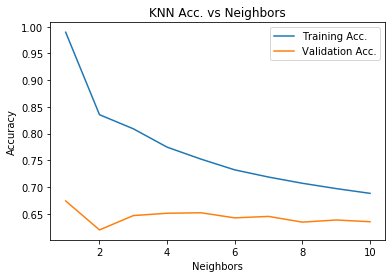

In [86]:
from sklearn.neighbors import KNeighborsClassifier

trains=[]
tests=[]

for i in range(10):
    neigh = KNeighborsClassifier(n_neighbors=i+1)
    train_preds=neigh.fit(X_train, y_train).predict(X_train)
    test_preds=neigh.fit(X_train, y_train).predict(X_test)

    trains.append(metrics.accuracy_score(y_train, train_preds))
    tests.append(metrics.accuracy_score(y_test, test_preds))

    
f, (ax2) = plt.subplots(1, 1)

ax2.plot(np.arange(1,11), trains)
ax2.plot(np.arange(1,11), tests)
plt.legend(["Training Acc.", "Validation Acc."])
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Neighbors')
ax2.set_title("KNN Acc. vs Neighbors")

As shown in the graph, we learn that using the 1 closest neighbor provides the model with the highest accuracy. We will use this model in our cross validation test below.

# PCA

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.33, random_state=42)

clf = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=2900,
            min_impurity_decrease=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_train)
print("DT Accuracy:", metrics.accuracy_score(y_train, y_pred))
y_pred = clf.predict(X_test)
print("DT Accuracy:", metrics.accuracy_score(y_test, y_pred))

clf = RandomForestClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=1600,
            min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None)
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_train)
print("RF Accuracy:", metrics.accuracy_score(y_train, y_pred))
y_pred = clf.predict(X_test)
print("RF Accuracy:", metrics.accuracy_score(y_test, y_pred))

DT Accuracy: 0.9764339706536238
DT Accuracy: 0.689103803997421


/Users/sawyer/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF Accuracy: 0.9468335133075018
RF Accuracy: 0.7246937459703418


In [20]:
scaler = preprocessing.MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
tensor_X_train = torch.tensor(X_train)
tensor_y_train = torch.tensor(y_train)
tensor_X_test = torch.tensor(X_test)
tensor_y_test = torch.tensor(y_test)
train_dataset = TensorDataset(tensor_X_train, tensor_y_train) 
test_dataset = TensorDataset(tensor_X_test, tensor_y_test)
train_dataloader = DataLoader(train_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [21]:
h = 120
model = FFNN(50, h, output_dim) # 72 is num of features
train_and_evaluate(30, model, train_dataloader, test_dataloader)

Training Loss: 1.3125873517730386
Training Accuracy: 0.47970526583243345


Testing Loss: 1.2655850118644618
Testing Accuracy: 0.4933591231463572


Training Loss: 1.2318936171616979
Training Accuracy: 0.5197865718096932


Testing Loss: 1.2402401147562792
Testing Accuracy: 0.521598968407479


Training Loss: 1.2080810755053015
Training Accuracy: 0.5323635901670584


Testing Loss: 1.2333098187898528
Testing Accuracy: 0.5292069632495164


Training Loss: 1.1901626139642596
Training Accuracy: 0.5401130661246268


Testing Loss: 1.2234275106765777
Testing Accuracy: 0.5324306898774984


Training Loss: 1.1744679354312482
Training Accuracy: 0.5475449406085244


Testing Loss: 1.2074452235814375
Testing Accuracy: 0.536428110896196


Training Loss: 1.1617379284311846
Training Accuracy: 0.5525630438925236


Testing Loss: 1.207569792223968
Testing Accuracy: 0.5359123146357189


Training Loss: 1.1513825265625255
Training Accuracy: 0.5541510512608778


Testing Loss: 1.1921105912045307
Testing Accuracy: 0.5374597034171502


Training Loss: 1.143292822642533
Training Accuracy: 0.5594232357238138


Testing Loss: 1.1859915472821678
Testing Accuracy: 0.5427466150870406


Training Loss: 1.1352260240941023
Training Accuracy: 0.562154608397383


Testing Loss: 1.1743689915678104
Testing Accuracy: 0.5450676982591877


Training Loss: 1.1285911413759253
Training Accuracy: 0.5649495013656863


Testing Loss: 1.1765320291813537
Testing Accuracy: 0.5435203094777563


Training Loss: 1.1224262650377155
Training Accuracy: 0.5673632725655847


Testing Loss: 1.177973035845466
Testing Accuracy: 0.5481624758220502


Training Loss: 1.1158463684930136
Training Accuracy: 0.5709839293654323


Testing Loss: 1.1622617006551674
Testing Accuracy: 0.5546099290780142


Training Loss: 1.1108713041224783
Training Accuracy: 0.5736517817442673


Testing Loss: 1.1682132311376696
Testing Accuracy: 0.5484203739522888


Training Loss: 1.1055821087334419
Training Accuracy: 0.575430349996824


Testing Loss: 1.1650323617730234
Testing Accuracy: 0.5490651192778853


Training Loss: 1.1010125678487324
Training Accuracy: 0.578479324144064


Testing Loss: 1.1593752660299217
Testing Accuracy: 0.5530625402965829


Training Loss: 1.0963995839164293
Training Accuracy: 0.5812106968176333


Testing Loss: 1.1686421576822519
Testing Accuracy: 0.5520309477756287


Training Loss: 1.0915883637843806
Training Accuracy: 0.5838150289017341


Testing Loss: 1.1561323904884506
Testing Accuracy: 0.555899419729207


Training Loss: 1.0867691391038172
Training Accuracy: 0.5848313536174807


Testing Loss: 1.1592307800332207
Testing Accuracy: 0.5557704706640877


Training Loss: 1.0838591317199386
Training Accuracy: 0.5861017595121641


Testing Loss: 1.1597586017519927
Testing Accuracy: 0.5547388781431335


Training Loss: 1.07899420459588
Training Accuracy: 0.5878803277647209


Testing Loss: 1.1572038108827625
Testing Accuracy: 0.5580915538362347


Training Loss: 1.0752052062665427
Training Accuracy: 0.5899764974909484


Testing Loss: 1.1579261914551315
Testing Accuracy: 0.559638942617666


Training Loss: 1.071338342652294
Training Accuracy: 0.5933430731118592


Testing Loss: 1.1523962275353863
Testing Accuracy: 0.5626047711154094


Training Loss: 1.0659813208341111
Training Accuracy: 0.5929619513434542


Testing Loss: 1.1425537176932816
Testing Accuracy: 0.5676337846550612


Training Loss: 1.0624408926224103
Training Accuracy: 0.5955027631328209


Testing Loss: 1.137681090045867
Testing Accuracy: 0.5647969052224371


Training Loss: 1.0575737306660054
Training Accuracy: 0.5965190878485677


Testing Loss: 1.1294118644952171
Testing Accuracy: 0.5700838168923276


Training Loss: 1.0537548634455325
Training Accuracy: 0.5981070952169218


Testing Loss: 1.1244584725848756
Testing Accuracy: 0.5756286266924565


Training Loss: 1.0490815110225824
Training Accuracy: 0.6023629549641111


Testing Loss: 1.1175755999583048
Testing Accuracy: 0.5824629271437782


Training Loss: 1.045223139251259
Training Accuracy: 0.6039509623324653


Testing Loss: 1.1186348425047887
Testing Accuracy: 0.578207607994842


Training Loss: 1.040670376206287
Training Accuracy: 0.6050308073429461


Testing Loss: 1.1043929491240514
Testing Accuracy: 0.5856866537717601


Training Loss: 1.0365940732447874
Training Accuracy: 0.6063647335323636


Testing Loss: 1.1069690591667607
Testing Accuracy: 0.5846550612508059



# Cross Validation

/Users/sawyer/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/sawyer/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/sawyer/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/sawyer/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20

Text(0.5, 1.0, 'KNN')

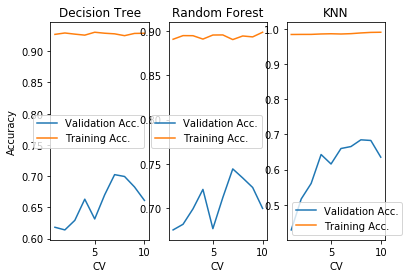

In [99]:
DT_clf = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=2900,
            min_impurity_decrease=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')
RF_clf = RandomForestClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=1600,
            min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None)

neigh = KNeighborsClassifier(n_neighbors=1)

from sklearn.model_selection import cross_validate

dt_results = cross_validate(DT_clf, X, y, return_train_score=True, cv=10)
rf_results = cross_validate(RF_clf, X, y, return_train_score=True,cv=10)
knn_results = cross_validate(neigh, X, y, return_train_score=True,cv=10)

import matplotlib.pyplot as plt

f, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.plot([1,2,3,4,5,6,7,8,9,10],dt_results['test_score'], label='Validation Acc.')
ax1.plot([1,2,3,4,5,6,7,8,9,10],dt_results['train_score'], label='Training Acc.')
ax1.legend(["Validation Acc.", "Training Acc."])
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('CV')
ax1.set_title("Decision Tree")

ax2.plot([1,2,3,4,5,6,7,8,9,10],rf_results['test_score'], label='Training Acc.')
ax2.plot([1,2,3,4,5,6,7,8,9,10],rf_results['train_score'], label='Validation Acc.')
ax2.legend(["Validation Acc.", "Training Acc."])
ax2.set_xlabel('CV')
ax2.set_title("Random Forest")

ax3.plot([1,2,3,4,5,6,7,8,9,10],knn_results['test_score'], label='Training Acc.')
ax3.plot([1,2,3,4,5,6,7,8,9,10],knn_results['train_score'], label='Validation Acc.')
ax3.legend(["Validation Acc.", "Training Acc."])
ax3.set_xlabel('CV')
ax3.set_title("KNN")